In [33]:
from unittest.mock import inplace

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import re
%matplotlib inline
pd.set_option('future.no_silent_downcasting', True)
pd.options.mode.copy_on_write = True

data = pd.DataFrame( pd.read_excel('./breast-cancer.xls') )  # Data Import from local/ Drive file


################# Data sanitisation #################
total_rows = len(data)
print("Data size before sanitisation, Total: ", total_rows)
data.dropna(inplace=True) # Drops all NA cells by row and saves it back to source data


print("Removed, Rows with NA: ", total_rows - len(data))
for x in data.index:

    if re.search( r"^[0-9]{1,2}-[0-9]{1,2}$",  str(data.loc[x, "age"]) ) is None and not ( re.search( r"^[0-9]{1,2}$",  str(data.loc[x, "age"])is None) ): #Using RegEx to confirm age pattern is not "XX-XX" / "X-XX" and not "XX"
        data.drop(index=x, inplace=True)
    elif re.search(r"^(ge40)$|^(premeno)$|^(lt40)$", str(data.loc[x, "menopause"])) is None:  #Using RegEx to confirm menopause name is only 1 of three
        data.drop(index=x, inplace=True)
    elif re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(data.loc[x, "tumor-size"]) ) is None:  #Using RegEx to confirm tumor size is formated correctly
        data.drop(index=x, inplace=True)
    elif re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(data.loc[x, "inv-nodes"])) is None: #Using RegEx to confirm node-caps is only yes or no Upper or lower case
        data.drop(index=x, inplace=True)
    elif re.match(r'^([Yy][eE][Ss]|[Nn][oO])$', str(data.loc[x, "node-caps"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
        data.drop(index=x, inplace=True)
    elif re.search(r"^1$|^2$|^3$", str(data.loc[x, "deg-malig"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
        data.drop(index=x, inplace=True)
    elif re.search(r"^([Ll][eE][fF][tT]|[Rr][Ii][Gg][hH][tT])$", str(data.loc[x, "breast"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
        data.drop(index=x)
    elif re.search(r"^(left_up|left_low|central|right_up|right_low)$", str(data.loc[x, "breast-quad"]), re.IGNORECASE) is None:
        data.drop(index=x)#Using RegEx to confirm inv-nodes count is a number range

    #Force only standard answer for this query, Yes / Recurence will = Recurrence-event, anything with no / non = Non-recurrence-event
    elif re.search(r"(non|no|recurrence|Yes)", str(data.loc[x, "Class"]), re.IGNORECASE) is None:
        data.loc[x, "Class"] = "Non-recurrence-event"
        if re.search(r"(non|no)", str(data.loc[x, "Class"]), re.IGNORECASE) :
            data.loc[x, "Class"] = "Non-recurrence-event"
        else:
            data.loc[x, "Class"] = "Recurrence-event"
        data.drop(index=x)

data.reset_index(drop=True, inplace=True)  # Re indexes entire dataframe to fix deleted rows
print("Total removal rows: " , total_rows - len(data))
################# Data sanitisation #################

################# Data Formating #################
def range_median(column):
    main_array = []
    for y in data.index:
        value = str(data.loc[y, column])
        if re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(value)) is not None:
            array = np.array(re.findall(r"[0-9]{1,2}", value), dtype=int)
            main_array.append(np.median(array))

        elif  re.search( r"^[0-9]{1,2}$",  value)is not None:
            array = np.array(re.findall(r"[0-9]{1,2}", value), dtype=int)
            main_array.append(np.median(array))
    data[str(column)] = main_array
    return main_array


def uniques_translator(column, inpalce_trigger):
    column_uniques = np.array(pd.unique(data[column]))
    translation_dictionary = {}
    for x in range(column_uniques.size):
        translation_dictionary.update({x : column_uniques[x]})
    if inpalce_trigger == True:
        data[str(column)] = data[[str(column)]].replace(column_uniques, translation_dictionary.keys())
        return data[[str(column)]]
    else:
        return data[[str(column)]].replace(column_uniques, translation_dictionary) , translation_dictionary

##  Dictionary of the change to revert back later    ##


numeric_Translation_Menopause = uniques_translator('menopause', False)
numeric_Translation_NodeCaps = uniques_translator('node-caps', False)
numeric_Translation_Breast = uniques_translator('breast', False)
numeric_Translation_irradiat = uniques_translator('irradiat', False)
numeric_Translation_Class = uniques_translator('Class', False)

##  Dictionary of the change to revert back later    ##

## Translating all string columns to int equivilant  ##

uniques_translator('menopause', True)
uniques_translator('node-caps', True)
uniques_translator('breast-quad', True)
uniques_translator('breast', True)
uniques_translator('irradiat', True)
uniques_translator('Class', True)
## Translating all string columns to int equivilant  ##
#range_median('age')


## Range medium finder for all non int only columns
range_median('age')
range_median('tumor-size')
range_median('inv-nodes')


################# Data Formating #################

################# Training Data Masking #################
training_data_per =  90/100.0

data['train'] = np.random.rand(len(data)) < training_data_per # Creates random array for each row  of Data, true or false using the fraction
Training_Data = data[data.train == 1] # Appends train Data with the array for each row, effectively showing which row at random will be removed

Training_Data = Training_Data.drop('train', axis=1).sample(frac=1)
################# Training Data Masking #################

################# Testing Data Seperation / Masking #################
Testing_Data = data[data.train == 0]
Testing_Data.drop('train', axis=1, inplace=True)

Training_Data = data[data.train == 1]
Training_Data.drop('train', axis=1, inplace=True)
#Using X to remove Class colum as Y will be the opposite, As it is the diagnoses column
#Y = 0  1
#    1  0
#    1  0
#    1  0
#    0  1
# == [0,0,0,1.....]
X = Training_Data.drop('Class', axis=1).to_numpy(dtype=float)

targets = [[1,0],[0,1]]
Y = np.array([targets[int(z[0])]  for z in Training_Data.values[:,8:9]])

################# Testing Data Seperation / Masking #################

################# Backpropagating data creation #################

NumberInput = len(X[0])
Hidden_layer_Rows = 9
#print(np.random.default_rng(seed=4))
weight1 = 2*np.random.random((NumberInput, Hidden_layer_Rows)) - 1


NumberOutputs = len(Y[0])
weight2 = 2*np.random.random((Hidden_layer_Rows, NumberOutputs)) - 1


print(weight1)
print(weight2)







################# Backpropagating data creation #################

################# Backpropagating data creation #################
# taken from> https://gist.github.com/craffel/2d727968c3aaebd10359
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)



# taken from> https://gist.github.com/craffel/2d727968c3aaebd10359
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)            
################# Backpropagating data creation #################


#fig = plt.figure(figsize=(12, 12))
#ax = fig.gca()
#ax.axis('off')
#draw_neural_net(ax, .1, .9, .1, .9, [4, 5, 3])




Data size before sanitisation, Total:  286
Removed, Rows with NA:  0
Total removal rows:  99
[[-5.71897588e-01  5.71152119e-01  1.47933497e-02  4.20611121e-01
  -5.56088225e-01 -5.56971850e-01 -4.74121109e-02  3.37299750e-01
   5.46549230e-02]
 [-9.73331131e-01 -5.39876161e-01 -5.17232119e-01 -8.60191096e-01
   5.01174441e-02  3.26579628e-01  1.79513342e-01  3.96447704e-01
   5.26894572e-01]
 [-8.02985956e-01  5.32442402e-01  1.26071547e-01 -9.25673493e-01
  -1.80375514e-01 -2.11906844e-01 -7.69426317e-01  6.09632954e-01
  -7.18131986e-01]
 [-1.04265055e-01 -5.00813309e-01  7.12084548e-03  1.41639905e-01
  -1.85232032e-01  8.92880286e-01 -7.23686389e-02 -2.88377579e-01
   9.66523832e-01]
 [ 3.58014882e-01 -6.18363452e-01  7.77495908e-01  6.23814962e-01
  -4.45580241e-01  7.98343470e-01 -1.59178951e-01  8.90938947e-01
   3.20142144e-01]
 [-5.13661033e-01  9.70741103e-01  1.76474453e-01 -2.46632450e-01
  -1.02832231e-01 -5.19788737e-02  4.04126918e-01 -9.83068284e-01
   9.18449392e-01]
 


Error: 0.13874540711684652


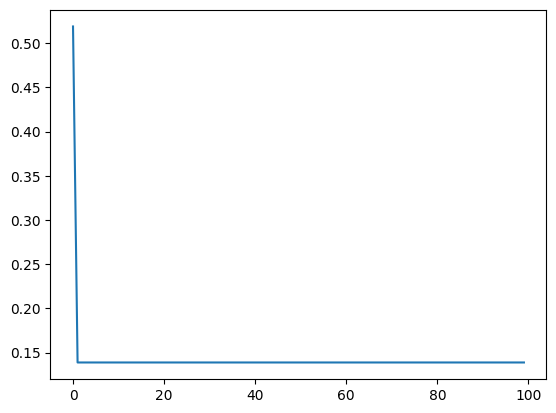

In [ ]:
learning_rate = 0.2 # slowly update the network
error = []

print(     )
for epoch in range(1000):
    # activate the first layer using the input
    #   matrix multiplication between the input and the layer 1 weights
    #   result is fed into a sigmoid function
    l1 = 1/(1 + np.exp(-(X @ weight1)))
    # activate the second layer using first layer as input
    l2 = 1/(1 + np.exp(-(l1 @ weight2)))
    # find the average errorof this batch
    #   using absolute, can use use square as well
    er = (abs(Y - l2)).mean()
    error.append(er)
    
    # BACKPROPAGATION / learning!
    # find contribution of error on each weight on the second layer
    l2_delta = (Y - l2)*(l2 * (1-l2))
    # update each weight in the second layer slowly
    weight2 += l1.T.dot(l2_delta) * learning_rate
    
    # find contribution of error on each weight on the second layer w.r.t the first layer
    l1_delta = l2_delta.dot(weight2.T) * (l1 * (1-l1))
    # udpate weights in the first layer
    weight1 += X.T.dot(l1_delta) * learning_rate
    
print('Error:', er)
plt.plot(error)